In [1]:
import scipy
import pandas as pd
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import networkx as nx

%load_ext rpy2.ipython

In [2]:
%%R

suppressPackageStartupMessages({
    library(cowplot)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

## Load overlapping community detection algorithm (OCDA) modules

In [3]:
# Read in OCDA modules
ocda_modules_glasser180_right = pd.read_csv("/Users/abry4213/github/OverlappingCommunityDetection_HCP/Results/table_of_modules_AF_renamed.csv")
ocda_modules_glasser180_right.columns = ["Glasser_RH_ROI", "module", "overlapping"]

# Load module orders
module_orders = pd.read_csv("module_order.csv")

## Load structural connectivity data

In [4]:
# Load in connectivity data
RH_connectivity_arr = scipy.io.loadmat('../Results/RH.mat')['RH']
RH_connectivity_df = pd.DataFrame(RH_connectivity_arr)

region_labels = pd.read_csv("../Results/brain_area_labels.csv", header=None)
region_labels.columns = ["region_index", "Glasser_RH_ROI"]
# Only keep first 180 rows of region_labels
region_labels = region_labels.iloc[:180, :]

# Subtract 10 from region_labels.region_index
region_labels["region_index"] = region_labels["region_index"] - 10

# Merge with ocda_modules_glasser180_right
region_labels = region_labels.merge(ocda_modules_glasser180_right, on="Glasser_RH_ROI", how="left")

In [5]:
%%R -i region_labels,RH_connectivity_df,ocda_modules_glasser180_right -o RH_connectivity_df_tidy,region_labels_tidy

regions_included <- ocda_modules_glasser180_right$Glasser_RH_ROI

region_labels_tidy <- region_labels %>%
    pull(Glasser_RH_ROI)

RH_connectivity_df_tidy <- RH_connectivity_df
colnames(RH_connectivity_df_tidy) <- rownames(RH_connectivity_df_tidy) <- region_labels_tidy[1:180]

module_order_for_connectogram <- c("Anterior frontal + cingulate and adj. cortex", 
                                   "Cingulate and adj. cortex + visual",
                                   "Visual + fronto-parietal",
                                   "Fronto-parietal + somatomotor",
                                   "Somatomotor + insula and post. temporal",
                                   "Insula and post. temporal + visual",
                                   "Anterior frontal",
                                   "Cingulate and adj. cortex",
                                   "Visual",
                                   "Fronto-parietal",
                                   "Somatomotor",
                                   "Insula and post. temporal")

RH_connectivity_df_tidy <- RH_connectivity_df_tidy %>%
    rownames_to_column(var="region_from") %>%
    pivot_longer(-region_from, names_to="region_to", values_to="SC") %>% 
    filter(region_from != region_to) %>% 
    left_join(., ocda_modules_glasser180_right, by=c("region_from"="Glasser_RH_ROI")) %>%
    dplyr::rename("module_from" = "module", "overlapping_from" = "overlapping") %>%
    left_join(., ocda_modules_glasser180_right, by=c("region_to"="Glasser_RH_ROI")) %>%
    dplyr::rename("module_to" = "module", "overlapping_to" = "overlapping")  %>%
    filter(overlapping_from=="Overlapping", region_from %in% regions_included, region_to %in% regions_included) %>%
    mutate(overlapping_to = factor(overlapping_to, levels=c("Overlapping", "Non-overlapping"))) %>%
    arrange(overlapping_to, module_to, region_to) %>% 
    mutate(module_to_num = as.numeric(factor(module_to, levels = module_order_for_connectogram)))

In [6]:
# Loading community structure as determined by Louvain
louvaincomm_Rubinov = scipy.io.loadmat('../Results/louvaincomm_Rubinov.mat')['louvaincomm_Rubinov']
# Loading community structure as determined by OSLOM
oslomcomm = scipy.io.loadmat('../Results/oslomcomm.mat')['oslomcomm']

## Load participation coefficient and within-module degree (z-scored) for Louvain and OSLOM-30 community assignments

In [7]:
network_stats = scipy.io.loadmat("../Results/network_stats.mat")

louvain_P = network_stats['louvain_P'].flatten()
louvain_z = network_stats['louvain_z'].flatten()


# Extract just the overlapping modules from ocda_modules_glasser180_right
overlapping_modules = ocda_modules_glasser180_right.query("overlapping == 'Overlapping'").rename(columns={"module": "overlapping_module"})

# Compile into dataframe
louvain_structure_df = pd.DataFrame({"Glasser_RH_ROI": region_labels.Glasser_RH_ROI, 
                                     "OSLOM_overlapping": region_labels.overlapping,  
                                     "OSLOM_module": region_labels.module,
                                     "louvain_P": louvain_P, "louvain_Z": louvain_z}).merge(overlapping_modules, how="left")



### Plot Z vs. P for Louvain

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "overlapping_module". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "overlapping". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


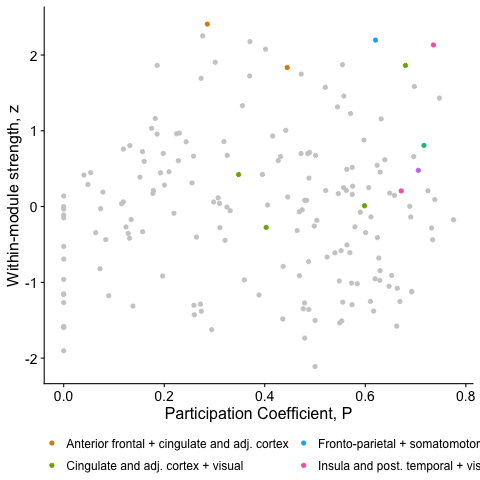

In [52]:
%%R -i louvain_structure_df

louvain_structure_df %>% 
    mutate(row_index = row_number()) %>%
    ggplot(data=., mapping=aes(x=louvain_P, y=louvain_Z, color=overlapping_module)) +
    geom_point(size=1.7) + 
    ylab("Within-module strength, z") +
    xlab("Participation Coefficient, P") +
    scale_color_manual(values=c("Anterior frontal + cingulate and adj. cortex" = "#de8c00",
                    "Cingulate and adj. cortex + visual" = "#7cae00",
                    "Visual + fronto-parietal" = "#00c08b",
                    "Fronto-parietal + somatomotor" = "#00b4f0",
                    "Somatomotor + insula and post. temporal" = "#c77cff",
                    "Insula and post. temporal + visual" = "#ff64b0"),
                    na.value = "gray80") +
    theme(legend.position="bottom",
          axis.title = element_text(size=16),
          axis.text = element_text(size=14),
          legend.title=element_blank())
# ggsave("../Plots/Louvain_community_stats.svg", width=4, height=4.5, units="in", dpi=300)

## Create additional nodes for overlapping OSLOM points [Matlab]

In [ ]:
%%bash 

# Define the path to the data
figure_path=$(echo $(pwd) | tr -d ' ')
github_path="$(dirname "$figure_path")"

# Define RH_in, RH_out, oslom_mat
RH_in=${github_path}/Results/RH.mat
RH_out=${github_path}/Results/RH_new.mat
oslom_mat=${github_path}/Results/oslomcomm.mat

# Run Matlab script to construct the overlapping duplicates
/Applications/MATLAB_R2023b.app/bin/matlab -nodisplay -singleCompThread -r "create_duplicated_adj $RH_in $RH_out $oslom_mat $github_path; exit"

In [8]:
RH_new = scipy.io.loadmat("../Results/RH_new.mat")
RH_connectivity_arr_new = RH_new['RH_new']
node_list = RH_new['nodeListTracking'].flatten().astype(int)
comm_labels_new = RH_new['oslomRHnew'].flatten()
oslom_P = network_stats['oslom_P'].flatten()
oslom_z = network_stats['oslom_z'].flatten()

module_lookup_table = {1: "Cingulate and adj. cortex",
                       2: "Anterior frontal",
                       3: "Insula and post. temporal",
                       4: "Somatomotor",
                       5: "Fronto-parietal",
                       6: "Visual"}

# Compile into dataframe
oslom_structure_df = (pd.DataFrame({"region_index": node_list + 180,
                                    "oslom_module": comm_labels_new,
              "oslom_P": oslom_P, 
              "oslom_z": oslom_z})
              .merge(region_labels, how="left")
              .drop(columns=["module"])
              # Apply lookup table
              .assign(module=lambda x: x["oslom_module"].map(module_lookup_table))
              .merge(overlapping_modules, how="left")
)


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "overlapping_module". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


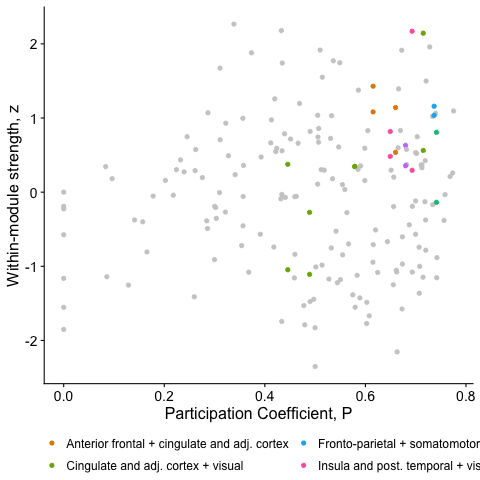

In [9]:
%%R -i oslom_structure_df

oslom_structure_df %>% 
    mutate(row_index = row_number()) %>%
    ggplot(data=., mapping=aes(x=oslom_P, y=oslom_z, color=overlapping_module)) +
    geom_point(size=1.7) + 
    ylab("Within-module strength, z") +
    xlab("Participation Coefficient, P") +
    scale_color_manual(values=c("Anterior frontal + cingulate and adj. cortex" = "#de8c00",
                    "Cingulate and adj. cortex + visual" = "#7cae00",
                    "Visual + fronto-parietal" = "#00c08b",
                    "Fronto-parietal + somatomotor" = "#00b4f0",
                    "Somatomotor + insula and post. temporal" = "#c77cff",
                    "Insula and post. temporal + visual" = "#ff64b0"),
                    na.value = "gray80") +
    theme(legend.position="bottom",
          axis.title = element_text(size=16),
          axis.text = element_text(size=14),
          legend.title=element_blank())
# ggsave("../Plots/OSLOM_community_stats.svg", width=4, height=4.5, units="in", dpi=300)

## Compare node 63 assignment in Louvain vs. OSLOM

In [10]:
# Keep all edges that connect to node 63 (with base 0, that's node 62 in Python)
keepNode = RH_connectivity_arr[62, :] > 0
keepNode[62] = True

# Subset region_labels to only include nodes in the subnetwork
region_labels_sub = region_labels[keepNode]
region_labels_sub['index_sub'] = range(region_labels_sub.shape[0])

# Subset RH_connectivity_arr rows and columns to only the indices in keepNode that are 1
RH_connectivity_arr_sub = RH_connectivity_arr[keepNode, :][:, keepNode]
# RH_connectivity_arr_sub = RH_connectivity_arr[keepNode
numNodes = RH_connectivity_arr_sub.shape[0]

# Filter community assignments to only include nodes in the subnetwork
lcomm = louvaincomm_Rubinov[keepNode].flatten()
ocomm = oslomcomm[keepNode]

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_2223/2196951939.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_labels_sub['index_sub'] = range(region_labels_sub.shape[0])


In [11]:
# Creating a list with community IDs since OSLOM output is in the form of a one-hot matrix
max_comm = ocomm.shape[1]
ocomm_list = np.zeros(numNodes)

for i in range(numNodes):
    # Community assignments for ith node
    comm_indices = ocomm[i, :]
    # Find index of each nonzero element in comms_i
    comms_i = np.nonzero(comm_indices)[0] + 1

    # Find number of indices
    ncomms_i = comms_i.shape[0]

    # Look for overlap
    if ncomms_i > 1:
        # Overlapping node between networks 1 + 2
        if ocomm[i,0] > 0 and ocomm[i,1] > 0:
            ocomm_list[i] = max_comm + 1
        elif ocomm[i,0] > 0 or ocomm[i,1] > 0:
            ocomm_list[i] = max_comm + 2
    else:
        ocomm_list[i] = comms_i[0]

# Create the list of nodes
nodelist = np.arange(1, numNodes + 1)

### Plot network graph based on Louvain community

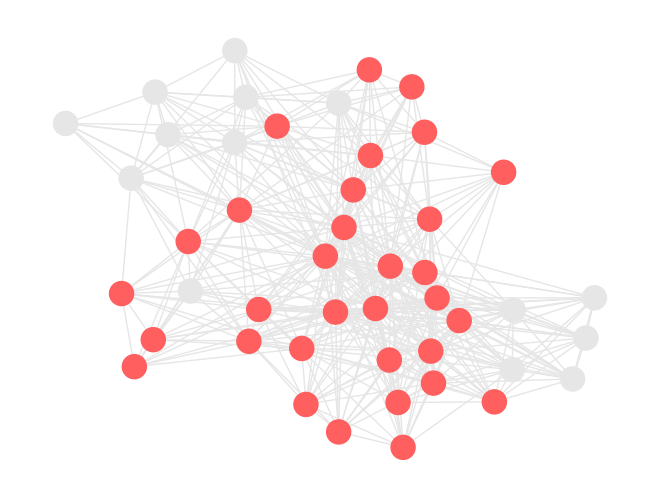

In [12]:
# Highlighting the nodes belong to community 2 which is split into several communities by OSLOM
nodes2_louvain = nodelist[lcomm == 2]

# Set the seed for a reproducible network graph
np.random.seed(127)

# Create a network graph from the subsetted adjacency matrix
G_louvain = nx.Graph(RH_connectivity_arr_sub)

# Color nodes by community in G
color_map = []
for node_base0 in G_louvain:
    node = node_base0 + 1
    if node in nodes2_louvain:
        color_map.append('#FF5F5E')
    else: 
        color_map.append('#E6E6E6')      
nx.draw(G_louvain, node_color=color_map, edge_color='#E6E6E6', with_labels=False)
# plt.savefig("../Plots/Louvain_network_graph.svg", format="SVG")

### Plot the network graph based on OSLOM communities

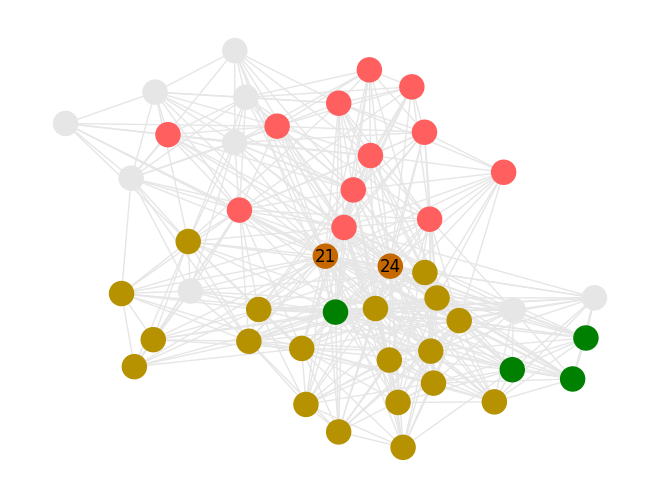

In [13]:
# Set the seed for a reproducible network graph
np.random.seed(127)

# Create a network graph from the subsetted adjacency matrix
G_oslom = nx.Graph(RH_connectivity_arr_sub)

# Find nodes that are in community 1 or 2, as well as overlapping nodes
nodes1_oslom = nodelist[ocomm_list == 1]
nodes2_oslom = nodelist[ocomm_list == 2]
nodes_overlapping_1_and_2_oslom = nodelist[ocomm_list == 7]
nodes_overlapping_other_oslom = nodelist[ocomm_list == 8]

# Check for all other (irrelevant) nodes where nodelist is in [3, 4, 5, 6]
all_other_nodes = nodelist[np.isin(ocomm_list, [3, 4, 5, 6])]

# Color nodes by community in G
labels = {}    
color_map = []
for node_base0 in G_oslom:
    node = node_base0 + 1
    # Color maps
    if node in nodes1_oslom:
        color_map.append('#B69200')
    elif node in nodes2_oslom:
        color_map.append('#FF5F5E')
    elif node in nodes_overlapping_1_and_2_oslom:
        color_map.append('#C66800')
        # Also append label
        labels[node_base0] = node_base0
    elif node in nodes_overlapping_other_oslom:
        color_map.append('green')
    else: 
        color_map.append('#E6E6E6')      

nx.draw(G_oslom, node_color=color_map, edge_color='#E6E6E6', with_labels=True,labels=labels)
# plt.savefig("../Plots/OSLOM_network_graph.svg", format="SVG")

### Compare P in Louvain vs. OSLOM

In [141]:
P_z_data_to_plot.head()

,Glasser_RH_ROI,overlapping,P,z,Partition,region_index,oslom_module,module,overlapping_module
1,R_V1_ROI,Non-overlapping,0.301397,1.904826,Louvain,-2147483648,-2147483648,None,None
2,R_MST_ROI,Non-overlapping,0.259731,-1.428084,Louvain,-2147483648,-2147483648,None,None
3,R_V6_ROI,Non-overlapping,0.174878,1.032289,Louvain,-2147483648,-2147483648,None,None
4,R_V2_ROI,Non-overlapping,0.369969,1.723602,Louvain,-2147483648,-2147483648,None,None
5,R_V3_ROI,Non-overlapping,0.370539,2.177136,Louvain,-2147483648,-2147483648,None,None


`summarise()` has grouped output by 'Glasser_RH_ROI', 'overlapping_module'. You
can override using the `.groups` argument.


In addition: Warning message:
Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


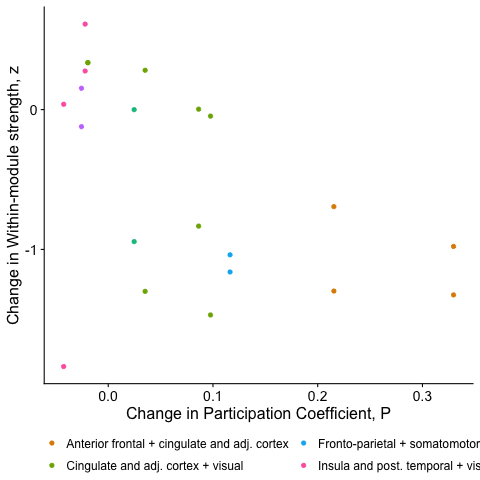

In [15]:
%%R -i P_z_data_to_plot -o delta_P_z_data

delta_P_z_data <- P_z_data_to_plot %>% 
    # Find difference in P and z from Louvain to OSLOM partition
    group_by(Glasser_RH_ROI, overlapping_module) %>%
    filter(overlapping=="Overlapping") %>%
    summarise(P_OSLOM_vs_Louvain = P[Partition == "OSLOM"] - P[Partition == "Louvain"],
           z_OSLOM_vs_Louvain = z[Partition == "OSLOM"] - z[Partition == "Louvain"]) %>%
    ungroup() %>% 
    distinct() 
    
delta_P_z_data %>% 
    ggplot(data=., mapping=aes(x=P_OSLOM_vs_Louvain, y=z_OSLOM_vs_Louvain, color=overlapping_module)) +
    geom_point(size=1.7) +
    ylab("Change in Within-module strength, z") +
    xlab("Change in Participation Coefficient, P") +
    scale_color_manual(values=c("Anterior frontal + cingulate and adj. cortex" = "#de8c00",
                    "Cingulate and adj. cortex + visual" = "#7cae00",
                    "Visual + fronto-parietal" = "#00c08b",
                    "Fronto-parietal + somatomotor" = "#00b4f0",
                    "Somatomotor + insula and post. temporal" = "#c77cff",
                    "Insula and post. temporal + visual" = "#ff64b0"),
                    na.value = "gray90") +
    theme(legend.position="bottom",
            axis.title = element_text(size=16),
            axis.text = element_text(size=14),
            legend.title=element_blank())
# ggsave("../Plots/Delta_P_vs_z_partitions.svg", width=3, height=4, units="in", dpi=300)

### What are the non-overlapping module groups in P vs. z space (OSLOM)?

In [16]:
oslom_structure_df.head()

,region_index,oslom_module,oslom_P,oslom_z,Glasser_RH_ROI,overlapping,module,overlapping_module
0,181,6,0.373458,1.880128,R_V1_ROI,Non-overlapping,Visual,NaN
1,182,6,0.259731,-1.411202,R_MST_ROI,Non-overlapping,Visual,NaN
2,183,6,0.286874,1.070259,R_V6_ROI,Non-overlapping,Visual,NaN
3,184,6,0.434670,1.741438,R_V2_ROI,Non-overlapping,Visual,NaN
4,185,6,0.432869,2.179457,R_V3_ROI,Non-overlapping,Visual,NaN


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "overlapping_module". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


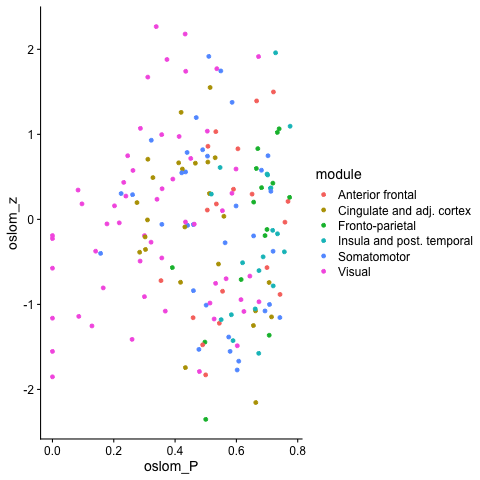

In [17]:
%%R -i oslom_structure_df

oslom_structure_df %>% 
    filter(overlapping=="Non-overlapping") %>% 
    ggplot(data=., mapping=aes(x=oslom_P, y=oslom_z, color=module)) +
    geom_point()